# **Μερική Διαφορική Εξίσωση (μη-γραμμική) Non-Linear Schrödinger 1D**

### *Γενική μορφή της ΜΔΕ NLS:*

$$
i\hbar\,\frac{\partial ψ(x,t)}{\partial t}
= -\frac{\hbar^2}{2m}\,\frac{\partial^2 ψ(x,t)}{\partial x^2}
+ g\,|ψ(x,t)|^2\,ψ(x,t)
$$

---

### *Τα σύμβολα:*
$$i \text{: φανταστική μονάδα (όχι εξασθένηση), } i^2=-1$$
$$\hbar \text{: μειωμένη σταθερά του Planck, }\hbar=\frac{h}{2\pi}$$
$$h \text{: σταθερά του Planck }$$
$$ψ(x,t)=ψ \text{: κυματοσυνάρτηση }$$
$$\frac{\partial ψ(x,t)}{\partial t} \text{: χρονική παράγωγος }$$
$$\frac{\partial^2 ψ(x,t)}{\partial x^2} \text{: χωρική παράγωγος (καμπυλότητα/διασπορά) }$$
$$m \text{: μάζα}$$
$$g \text{: συντελεστής μη γραμμικότητας}$$

$$ \text {Όταν g θετικό -> εστίαση, το κύμα συγκεντρώνεται}$$
$$ \text {Όταν g αρνητικό -> απεστίαση, το κύμα απλώνεται}$$

---

### **Προσεγγίζουμε την ΜΔΕ NLS:**

$$
i\, \partial_t ψ(x,t) + p\, \partial_{xx} ψ(x,t) + q\,|ψ(x,t)|^2\,ψ(x,t) = 0
$$

**με**


$$x \in \left[-\frac{L}{2},\frac{L}{2}\right]=[-20,20]$$

$$t \in [0,T]=[0,5]$$

---

### **Αρχική συνθήκη:**

$$
ψ(x,0) = A\ sech(ψ_0\ x)\ e^{i(c\ x )}
$$

**με**

$$A=\sqrt{\frac{2|p|}{|q|}}\ ψ_0 $$

---

### **Συνοριακές συνθήκες: (Περιοδικές)**

$$
ψ\left(-\frac{L}{2},t\right)=ψ\left(\frac{L}{2},t\right)
$$
$$
ψ_x\left(-\frac{L}{2},t\right)=ψ_x\left(\frac{L}{2},t\right)
$$

---

### *Πραγματοποιούμε χωρισμό πραγματικού και φανταστικού μέρους:*

$$ ψ = u + i\ v $$

###*τότε για την NLS:*
$$
\text{Πραγματικό μέρος: } ψ_{re} =
-v_t + p\ u_{xx} + q\ (u^2 + v^2)u = 0
$$

$$
\text{Φανταστικό μέρος: } ψ_{im} =
u_t + p\ v_{xx} + q\ (u^2 + v^2) v = 0
$$

---
$$$$
$$e^{ix} = cos(x) + i\ sin(x)$$

###*τότε για την Αρχική Συνθήκη*

$$
\text{Πραγματικό μέρος: } ψ_{re}(x,0) = A\ sech(ψ_0\ x)\ cos(c\ x)
$$

$$
\text{Φανταστικό μέρος: } ψ_{im}(x,0) = A\ sech(ψ_0\ x)\ sin(c\ x)
$$


In [ ]:
import torch #βασικό πακέτο PyTorch
import torch.nn as nn #έτοιμες συναρτήσεις για νν
import torch.nn.functional as f #συναρτήσεις ενεργοποίησης
import torch.optim as optim #βελτιστοποιητές
import numpy as np #βιβλιοθήκη αριθμητικών υπολογισμών
from time import time #μέτρηση χρόνου
import gc #για καθαρισμό cpu
import platform #για το τι συσκευή cpu χρησιμοποιώ


use_cuda = input("Να κεράσω CUDA; (ναι/οχι): ").strip().lower()

if use_cuda == "ναι":
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

print("Χρήση συσκευής:", device)
print(torch.__version__)

print(torch.cuda.is_available())
if torch.cuda.is_available():
  print("Κερασμένη η CUDA!")
  print("Current device:", torch.cuda.current_device())
  print("Device name:", torch.cuda.get_device_name(0))
  torch.cuda.empty_cache() # άδειασμα gpu
else:
  print("Μας τελείωσε η CUDA...")
  print(platform.uname())
  gc.collect() # άδειασμα cpu

#Ζέσταμα GPU για να μην πετάει warning
if device.type == "cuda":
    torch.cuda.init()
    torch.cuda.empty_cache()
    torch.randn(8, 8, device=device) #warm-up cuBLAS

Να κεράσω CUDA; (ναι/οχι): oxi
Χρήση συσκευής: cpu
2.9.0+cpu
False
Μας τελείωσε η CUDA...
uname_result(system='Linux', node='6a5b89b028cf', release='6.6.105+', version='#1 SMP Thu Oct  2 10:42:05 UTC 2025', machine='x86_64')


In [ ]:
#ορισμός ακρίβειας
dtype = torch.float32

#Σταθερές
p = torch.tensor(0.5, dtype=dtype, device=device) #συντελεστής διασποράς
q = torch.tensor(1.0, dtype=dtype, device=device) #συντελεστής μη-γραμμικότητας

psi_zero = torch.tensor(1.0, dtype=dtype, device=device) #παράμετρος σχήματος / εύρους του σολιτόνιου
A = torch.sqrt(2 * torch.abs(p) / torch.abs(q)) * psi_zero #μέγιστο πλάτος σολιτονίου
c = torch.tensor(0.5, dtype=dtype, device=device) #σχετίζεται με την φάση/ταχύτητα του σολιτονίου
v_sp = 2 * c * torch.abs(p) #ταχύτητα του σολιτονίου
k = c #κυματάριθμος
omega = ( c**2 - psi_zero**2 ) * torch.abs(p) #συχνότητα


L=40 #συνολικό πλάτος χώρου
L_min = torch.tensor(-L/2, dtype=dtype, device=device) #πλάτος χώρου ελάχιστο
L_max = torch.tensor(L/2, dtype=dtype, device=device) #πλάτος χώρου μεγιστο
T_max = torch.tensor(5, dtype=dtype, device=device) #χρόνος

#Αρχική Συνθήκη
def fun_psi_0(t,x):
    #Χωρισμός πραγματικού και φανταστικού μέρους
    #Κατασκευή δύο καναλιών
    u_0 = A / torch.cosh(psi_zero*x) * torch.cos(c*x)   #πραγματικό μέρος
    v_0 = A / torch.cosh(psi_zero*x) * torch.sin(c*x)   #φανταστικό μέρος
    return u_0, v_0

#Συνοριακές Συνθήκες
def fun_psi_b_left(t,x):
    #Στις περιοδικές δεν έχω αντίστοιχη συνάρτηση
    #Ενσωματώνονται στο training loop και loss
    return None

def fun_psi_b_right(t,x):
    #Στις περιοδικές δεν έχω αντίστοιχη συνάρτηση
    #Ενσωματώνονται στο training loop και loss
    return None

#ΜΔΕ Εξίσωση NLS
def fun_r(u, v, u_t, v_t, u_xx, v_xx):
    res_re = -v_t + p * u_xx + q * (u**2 + v**2) * u #πραγματικό μέρος
    res_im = u_t + p * v_xx + q * (u**2 + v**2) * v  #φανταστικό μέρος
    return res_re, res_im


In [ ]:
#Χαρακτηριστικά Soliton

print("----------------------------\n")
print("Παράμετροι Soliton:\n")
print(f"p = {p}, q = {q}, ψ_0 = {psi_zero}, c = {c}")
print(f"A = {A.item():+.4f}")
print(f"v_sp = {v_sp.item():+.4f}")
print(f"k = {k.item():+.4f}")
print(f"ω = {omega.item():+.4f}")
print("\n----------------------------\n")

print("Χαρακτηριστικά Soliton:\n")

if omega < 0:
    print("1)Το soliton έχει αρνητική συχνότητα.")
elif omega > 0:
    print("1)Το soliton έχει θετική συχνότητα.")
else:
    print("1)Το soliton έχει μηδενική συχνότητα (καμία ταλάντωση)")

if v_sp == 0:
    print("2)Το soliton είναι στάσιμο (δεν κινείται).")
elif v_sp > 0:
    print("2)Το soliton κινείται προς τα δεξιά.")
else:
    print("2)Το soliton κινείται προς τα αριστερά.")

if p/q > 0:
    print("3)Focusing NLS - Φωτεινό soliton.")
elif p/q < 0:
    print("3)Defocusing NLS - Σκοτεινό soliton.")
else:
    print("3)Σφάλμα, δεν μπορώ q=0.")


print("\n----------------------------")

----------------------------

Παράμετροι Soliton:

p = 0.5, q = 1.0, ψ_0 = 1.0, c = 0.5
A = +1.0000
v_sp = +0.5000
k = +0.5000
ω = -0.3750

----------------------------

Χαρακτηριστικά Soliton:

1)Το soliton έχει αρνητική συχνότητα.
2)Το soliton κινείται προς τα δεξιά.
3)Focusing NLS - Φωτεινό soliton.

----------------------------


In [ ]:
#Αριθμός σημείων
N_0 = 400 #πλήθος αρχικής συνθήκες u(x,0)
N_b = 500 #πλήθος συνοριακών συνθηκών u(±L, t)
N_r = 2000 #πλήθος στο εσωτερικό του πεδίου εκπαίδευσης της ΜΔΕ

#Συνοριακές τιμές
tmin = torch.tensor(0, dtype=dtype, device=device)
tmax = T_max
xmin = L_min
xmax = L_max

In [ ]:
print(f'Τα όρια του χωροχρονικού πεδίου σε μορφή tensor:\n')
print(f'[tmin,tmax] x [xmin,xmax]')
print(f'[{tmin}, {tmax.item()}] x [{xmin.item()}, {xmax.item()}]\n')

Τα όρια του χωροχρονικού πεδίου σε μορφή tensor:

[tmin,tmax] x [xmin,xmax]
[0.0, 5.0] x [-20.0, 20.0]



In [ ]:
#Κάτω όριο
lb = torch.tensor([tmin, xmin], dtype=dtype, device=device)
#Πάνω όριο
ub = torch.tensor([tmax, xmax], dtype=dtype, device=device)

In [ ]:
print(f'lb:', lb.device)
print(f'ub:', ub.device)

lb: cpu
ub: cpu


In [ ]:
#Σταθεροποίηση γεννήτριας τυχαίων αριθμών
torch.manual_seed(67)

In [ ]:
#Δημιουργία σημείων αρχικών συνθηκών


#στήλη με την αρχική τιμή του χρόνου
###t_0 = torch.ones((N_0,1), dtype=dtype, requires_grad=True, device=device)*lb[0]
t_0 = torch.ones((N_0,1), dtype=dtype, device=device)*lb[0]

#στήλη με τυχαίους στο διάστημα [xmin,xmax]
###x_0 = torch.rand((N_0,1), dtype=dtype, requires_grad=True, device=device)*(ub[1]-lb[1]) + lb[1]
x_0 = torch.rand((N_0,1), dtype=dtype, device=device)*(ub[1]-lb[1]) + lb[1]

#Συνδιασμός σε tensor (N0,2) ##δύο στήλες t0,x0
X_0 = torch.concat([t_0, x_0], dim=1)

In [ ]:
print(f't_0: ',t_0.shape)
print(f'x_0: ',x_0.shape)
print(f'X_0: ',X_0.shape)
print(f't_0: ',t_0.device)
print(f'x_0: ',x_0.device)
print(f'X_0: ',X_0.device)

t_0:  torch.Size([400, 1])
x_0:  torch.Size([400, 1])
X_0:  torch.Size([400, 2])
t_0:  cpu
x_0:  cpu
X_0:  cpu


In [ ]:
#Υπολογισμός αρχικής συνθήκης
u_0, v_0 = fun_psi_0(t_0, x_0)

In [ ]:
print(f'u_0: ',u_0.shape)
print(f'v_0: ',v_0.shape)
print(f'u_0: ',u_0.device)
print(f'v_0: ',v_0.device)

u_0:  torch.Size([400, 1])
v_0:  torch.Size([400, 1])
u_0:  cpu
v_0:  cpu


In [ ]:
# Δημιουργία σημείων συνοριακών συνθηκών


#στήλη με τυχαίους στο διάστημα [tmin, tmax]
t_b = torch.rand((N_b,1), dtype=dtype, requires_grad=True, device=device)*(ub[0]-lb[0]) + lb[0]

#στήλη με N_b στοιχεία για το xmin σύνορο (αριστερά)
x_b_left = torch.ones((N_b, 1), dtype=dtype, requires_grad=True, device=device)*lb[1]

#στήλη με N_b στοιχεία για το xmax σύνορο (δεξιά)
x_b_right = torch.ones((N_b, 1), dtype=dtype, requires_grad=True, device=device)*ub[1]

#Συνδιασμός σε tensor (N_b,3)
X_b = torch.concat([t_b, x_b_left, x_b_right], dim=1)

In [ ]:
print(f't_b:       ',t_b.shape)
print(f'x_b_left:  ',x_b_left.shape)
print(f'x_b_right: ',x_b_right.shape)
print(f'X_b:       ',X_b.shape)
print(f't_b:       ',t_b.device)
print(f'x_b_left:  ',x_b_left.device)
print(f'x_b_right: ',x_b_right.device)
print(f'X_b:       ',X_b.device)

t_b:        torch.Size([500, 1])
x_b_left:   torch.Size([500, 1])
x_b_right:  torch.Size([500, 1])
X_b:        torch.Size([500, 3])
t_b:        cpu
x_b_left:   cpu
x_b_right:  cpu
X_b:        cpu


In [ ]:
#Υπολογισμός Συνοριακών Συνθηκών

#Αυτό το κομμάτι κώδικα στις περιοδικές δεν χρειάζεται.
#Δεν έχουμε να υπολογίσουμε κάτι, θέλουμε απλά να είναι ίσες.

In [ ]:
#Τυχαία σημεία λύσης

#Δημιουργία τυχαίων τιμών στο χρόνο [tmin, tmax]
t_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True, device=device)*(ub[0]-lb[0]) + lb[0]

#Δημιουργία τυχαίων τιμών στο χώρο [xmin, xmax]
x_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True, device=device)*(ub[1]-lb[1]) + lb[1]

#Συνδιασμός σημείων σε tensor (N_r,2)
X_r = torch.concat([t_r, x_r], dim=1)

In [ ]:
print(f't_r: ',t_r.shape)
print(f'x_r: ',x_r.shape)
print(f'X_r: ',X_r.shape)
print(f't_r: ',t_r.device)
print(f'x_r: ',x_r.device)
print(f'X_r: ',X_r.device)

t_r:  torch.Size([2000, 1])
x_r:  torch.Size([2000, 1])
X_r:  torch.Size([2000, 2])
t_r:  cpu
x_r:  cpu
X_r:  cpu


In [ ]:
#λίστες

#(Ν_0,2) αρχικά σημεία, (Ν_b,3) συνοριακά σημεία
X_data = [X_0, X_b]

#(Ν_0,2) αρχικές τιμές
psi_data = [u_0, v_0]

In [ ]:
print(f'X_0: ',X_data[0].shape)
print(f'X_b: ',X_data[1].shape)
print(f'u_0: ',psi_data[0].shape)
print(f'v_0: ',psi_data[0].shape)
print(f'X_0: ',X_data[0].device)
print(f'X_b: ',X_data[1].device)
print(f'u_0: ',psi_data[0].device)
print(f'v_0: ',psi_data[0].device)

X_0:  torch.Size([400, 2])
X_b:  torch.Size([500, 3])
u_0:  torch.Size([400, 1])
v_0:  torch.Size([400, 1])
X_0:  cpu
X_b:  cpu
u_0:  cpu
v_0:  cpu


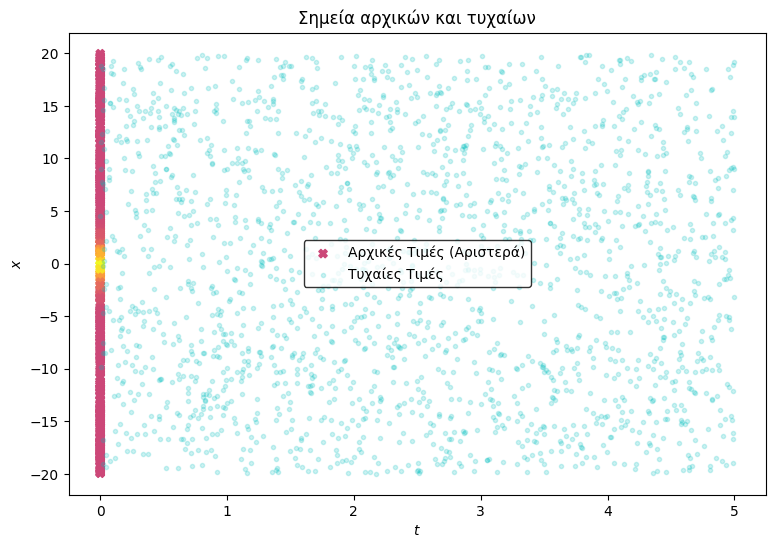

In [ ]:
import matplotlib.pyplot as plt #βιβλιοθήκη γραφήματα

fig = plt.figure(figsize=(9,6)) #καμβάς 9x6 ίντσες
color = 'plasma' #επιλογή χρώματος γραφίματος

psi0_abs = torch.sqrt(u_0**2 + v_0**2) #μέτρο κυματοσυνάρτησης

#σημεία αρχικής συνθήκης
plt.scatter(t_0.cpu().detach(), x_0.cpu().detach(), c=psi0_abs.cpu().detach(), marker='X', vmin=-1, vmax=1, cmap=color, label='Αρχικές Τιμές (Αριστερά)')

#σημεία τυχαία
plt.scatter(t_r.cpu().detach(), x_r.cpu().detach(), c='c', marker='.', alpha=0.2, label='Τυχαίες Τιμές')

plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend(loc='center').get_frame().set_edgecolor('black')
plt.title('Σημεία αρχικών και τυχαίων');

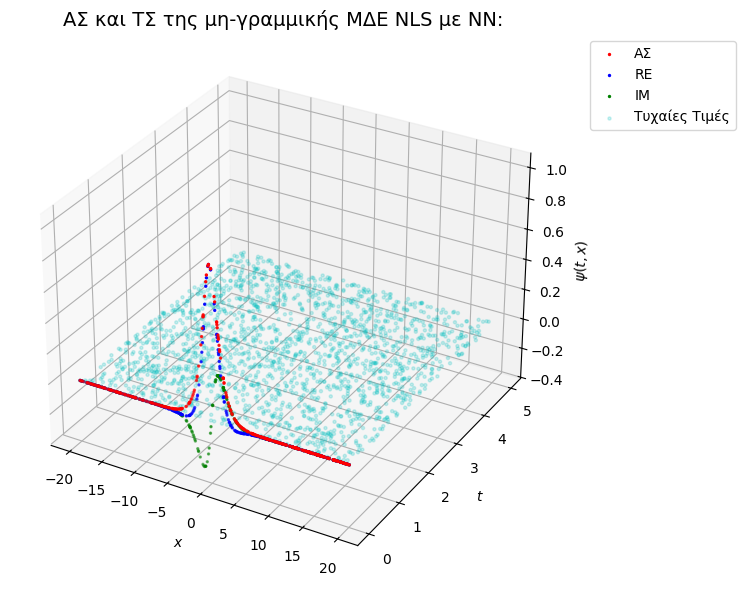

Στο t=Τ έχουμε min ψ_0 = 0.000, max ψ_0 = 0.998
Στο t=Τ έχουμε min u_0 = -0.015, max u_0 = 0.997
Στο t=Τ έχουμε min v_0 = -0.313, max v_0 = 0.313


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

psi0_abs = torch.sqrt(u_0**2 + v_0**2) #μέτρο κυματοσυνάρτησης

#Αρχική Συνθήκη
ax.scatter(x_0.detach().cpu().numpy(), t_0.detach().cpu().numpy(), psi0_abs.detach().cpu().numpy(), color='r', label='ΑΣ', s=2);
ax.scatter(x_0.detach().cpu().numpy(), t_0.detach().cpu().numpy(), u_0.detach().cpu().numpy(), color='b', label='RE', s=2);
ax.scatter(x_0.detach().cpu().numpy(), t_0.detach().cpu().numpy(), v_0.detach().cpu().numpy(), color='g', label='IM', s=2);

#σημεία τυχαία
ax.scatter(x_r.cpu().detach(), t_r.cpu().detach(), c='c', marker='.', alpha=0.2, label='Τυχαίες Τιμές')

ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$ψ(t,x)$')
ax.set_title(r'ΑΣ και ΤΣ της μη-γραμμικής ΜΔΕ NLS με NN:', fontsize=14);
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Μέγιστο πλάτος στο t_max
PSI0_min = psi0_abs.min().item()
PSI0_max = psi0_abs.max().item()
print(f'Στο t=Τ έχουμε min ψ_0 = {PSI0_min:.3f}, max ψ_0 = {PSI0_max:.3f}')

u0_min = u_0.min().item()
u0_max = u_0.max().item()
print(f'Στο t=Τ έχουμε min u_0 = {u0_min:.3f}, max u_0 = {u0_max:.3f}')

v0_min = v_0.min().item()
v0_max = v_0.max().item()
print(f'Στο t=Τ έχουμε min v_0 = {v0_min:.3f}, max v_0 = {v0_max:.3f}')

In [ ]:
#Δημιουργία ΝΝ

class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=20):
        super(NeuralNetwork, self).__init__()

        #Το input layer συνδέεται στο 1ο layer (με 20 νευρώνες)
        self.input_layer = nn.Linear(2, num_neurons_per_layer)

        #Τα layers από το 1ο μέχρι το 8ο
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer,num_neurons_per_layer)

            for _ in range(num_hidden_layers)
        ])

        #Το output layer δίνει 2 τιμές: u και v
        self.output_layer = nn.Linear(num_neurons_per_layer, 2)

        #Αρχικοποίηση βαρών
        self._initialize_weights()

    def _initialize_weights(self):
       for layer in self.hidden_layers:
            #αποτρέπει τα πολύ μεγάλα και πολύ μικρά βάρη
            nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        #Μετασχηματιμσός του x για να βρίσκεται στο [lb[1], ub[1]]=[xmin,xmax]=[-1,1] για ταχύτερη επκπαίδευση με την tanh
        x = 2.0*(x - lb)/(ub - lb) - 1.0

        #Το input layer
        x = torch.tanh(self.input_layer(x))

        #1ο με 8ο hidden layer
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x)) #+ 0.1 * x #skip connection ή residual connection

        #Το output layer
        x = self.output_layer(x)
        u = x[:, 0:1]  # πραγματικό μέρος
        v = x[:, 1:2]  # φανταστικό μέρος

        return u, v

In [ ]:
#Υπολογισμός Απώλειας

mse_loss = nn.MSELoss() #Μέσο Τετραγωνικό Σφάλμα

def compute_loss(model, X_r, X_data, psi_data, epoch, verbose_flag):

    ##Απώλεια ΜΔΕ
    #Σπάσιμο στηλών t,x για να υπολογιστούν ξεχωριστά οι μερικές παράγωγοι
    t = X_r[:,0:1]#.detach().requires_grad_(True)
    x = X_r[:,1:2]#.detach().requires_grad_(True)

    #Εκτίμηση ΜΔΕ μοντέλου
    u, v = model(torch.concat([t,x],dim=1)) #u = psi_re, v = psi_im

    #Υπολογισμός Μερικών Παραγώγων Πραγματικού και Φανταστικού Μέρους
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]

    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]


    #Υπολογισμός του απώλειας της ΜΔΕ
    f_u, f_v = fun_r(u, v, u_t, v_t, u_xx, v_xx)
    l_u = torch.mean(torch.square(f_u))
    l_v = torch.mean(torch.square(f_v))
    l_psi = l_u + l_v

    ##Απώλεια αρχικής συνθήκης
    #Σπάσιμο του t0,x0 για να υπολογιστεί ξεχωριστά η μερική παράγωγος
    t0 = X_data[0][:,0:1]#.clone().detach().requires_grad_(True)
    x0 = X_data[0][:,1:2]#.detach().requires_grad_(True)

    #Εκτίμηση μοντέλου για την θέση και ταχύτητα
    u0, v0 = model(torch.concat([t0, x0],dim=1))

    #Υπολογισμός απώλειας θέσης και ταχύτητας
    l_u0 = torch.mean(torch.square(psi_data[0]-u0))
    l_v0 = torch.mean(torch.square(psi_data[1]-v0))
    l_0 = l_u0 + l_v0


    ##Απώλεια συνοριακών τιμών (Περιοδικές)
    #Σπάσιμο στηλών t,xl,xr για να υπολογιστούν ξεχωριστά οι μερικές παράγωγοι
    tb = X_data[1][:,0:1]#.clone().detach().requires_grad_(True)
    xbl = X_data[1][:,1:2]#.detach().requires_grad_(True)
    xbr = X_data[1][:,2:3]#.detach().requires_grad_(True)

    #Εκτίμηση μοντέλου Αριστερά μαζί με παραγώγους
    ubl, vbl = model(torch.concat([tb, xbl],dim=1))
    ubl_x = torch.autograd.grad(ubl, xbl, grad_outputs=torch.ones_like(ubl), create_graph=True, allow_unused=True)[0]
    vbl_x = torch.autograd.grad(vbl, xbl, grad_outputs=torch.ones_like(ubl), create_graph=True, allow_unused=True)[0]

    #Εκτίμηση μοντέλου Δεξιά
    ubr, vbr = model(torch.concat([tb, xbr],dim=1))
    ubr_x = torch.autograd.grad(ubr, xbr, grad_outputs=torch.ones_like(ubr), create_graph=True, allow_unused=True)[0]
    vbr_x = torch.autograd.grad(vbr, xbr, grad_outputs=torch.ones_like(ubr), create_graph=True, allow_unused=True)[0]

    #Υπολογισμός απώλειας συνοριακών συνθηκών
    l_u_lr = mse_loss(ubl, ubr)
    l_u_x_lr = mse_loss(ubl_x, ubr_x)
    l_v_lr = mse_loss(vbl, vbr)
    l_v_x_lr = mse_loss(vbl_x, vbr_x)
    l_b = l_u_lr + l_v_lr + l_u_x_lr + l_v_x_lr

    #Προσαρμογή Βαρών κάθε loss
    w_psi = 100
    w_b = 1
    w_0 = 10

    #Συνολική απώλεια
    loss = w_psi * l_psi + w_b * l_b + w_0 * l_0

    if (epoch % 100 == 0) and (verbose_flag != -1):
      print(f'Epoch {epoch:05d}: l_psi = {l_psi:10.8e}, l_b = {l_b:10.8e}, l_0 = {l_0:10.8e}, loss = {loss:10.8e}')
      #print(f'Epoch {epoch:05d}: w_psi = {w_psi:.2f}, w_b = {w_b:.2f}, w_0 = {w_0:.2f}')

    return loss

In [ ]:
model = NeuralNetwork().to(device)

# Έλεγχος ότι το μοντέλο πήγε στη GPU
print("Model is on:", next(model.parameters()).device)

#Σταθερά learning rate
lr_schedule = [1e-3, 1e-4, 1e-5]
def get_lr(epoch):
    if epoch < 1000:
        return lr_schedule[0]
    elif epoch < 3000:
        return lr_schedule[1]
    else:
        return lr_schedule[2]

#Adam βελτιστοποιητής
optimizer = optim.Adam(model.parameters(), lr=lr_schedule[0])

Model is on: cpu


In [ ]:
#Αριθμός εποχών
epoch = 2000

#Λίστα απώλειας κάθε εποχής
losses = []

#Καταγραφή χρόνου (σε δευτερόλεπτα)
sec = time()

for i in range(epoch + 1):

    #Ενημέρωση της σταθεράς learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = get_lr(i)

    #Μηδενισμός των παραγώγων του βελτιστοποιητή πριν το backpropagation
    optimizer.zero_grad()

    #Υπολογισμός σφάλματος
    loss = compute_loss(model, X_r, X_data, psi_data, i, verbose_flag=1)

    #Έλεγχος ποιες παράμετροι δεν είναι CUDA
    #for name, param in model.named_parameters():
        #if param.device.type != 'cuda':
            #print("Parameter on CPU:", name, param.device)

    #Υπολογισμός των παραγώγων τρέχουσας εποχής
    loss.backward(retain_graph=True)

    #Ενημέρωση βαρών επόμενης εποχής
    optimizer.step()

    #Αποθήκευση του σφάλματος κάθε εποχής
    losses.append(loss.item())

    #Εφαρμογή του early stopping
    if loss.item() < 1e-5:
       break

#Εμφάνιση χρόνου εκτέλεσης του μοντέλου
seconds = time() - sec
days = seconds // (24*60*60)
hours = (seconds % (24*60*60)) // (60*60)
minutes = (seconds % (60*60)) // 60
second = int(seconds % 60)
print(f'\nΧρόνος Εκπαίδευσης Μοντέλου: {int(days)} μέρες, {int(hours)} ώρες, {int(minutes)} λεπτά, {int(second)} δευτερόλεπτα')
print(f'\nEpochs: {i}, loss = {losses[i]:10.8e}')


Epoch 00000: l_psi = 6.32465701e-04, l_b = 1.13633648e-02, l_0 = 9.98488218e-02, loss = 1.07309818e+00
Epoch 00100: l_psi = 3.40203769e-05, l_b = 2.55058752e-04, l_0 = 2.97157392e-02, loss = 3.00814509e-01
Epoch 00200: l_psi = 2.18192581e-04, l_b = 1.80231087e-04, l_0 = 3.98696912e-03, loss = 6.18691817e-02
Epoch 00300: l_psi = 1.16995870e-04, l_b = 1.68537099e-05, l_0 = 1.05721829e-03, loss = 2.22886242e-02
Epoch 00400: l_psi = 8.80194711e-05, l_b = 7.59292889e-05, l_0 = 6.26423745e-04, loss = 1.51421139e-02
Epoch 00500: l_psi = 5.92590950e-05, l_b = 1.61228054e-05, l_0 = 5.01396251e-04, loss = 1.09559949e-02
Epoch 00600: l_psi = 4.77428366e-05, l_b = 1.30113040e-05, l_0 = 3.12335120e-04, loss = 7.91064650e-03
Epoch 00700: l_psi = 3.35523291e-05, l_b = 1.27447493e-05, l_0 = 2.78678461e-04, loss = 6.15476258e-03
Epoch 00800: l_psi = 2.53980725e-05, l_b = 7.50024765e-06, l_0 = 1.79268289e-04, loss = 4.33999021e-03
Epoch 00900: l_psi = 2.03842010e-05, l_b = 1.34887250e-05, l_0 = 1.414451

In [ ]:
# Fine-tuning με L-BFGS
#Καταγραφή χρόνου (σε δευτερόλεπτα)
sec = time()


lbfgs_counter = 0  #μετρητής βημάτων LBFGS

optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),    #μεταβολή των βαρών του μοντέλου
                                    max_iter=500,          #μέγιστος αριθμός εσωτερικών βημάτων
                                    tolerance_grad=1e-7,   #έξοδος όταν η μέση κλίση είναι μικρότερη από
                                    tolerance_change=1e-9, #έξοδος όταν τα βάρη είναι μικρότερα από
                                    history_size=20,       #πόσα προηγούμενα βήματα να θυμάται για την εκτίμηση της Hessian
                                    line_search_fn="strong_wolfe") #για σταθερή σύγκλιση, αποφυγεί πολύ μικρών/μεγάλων βημάτων

def closure():
    optimizer_lbfgs.zero_grad() #μηδενισμός προηγούμενων gradients
    loss = compute_loss(model, X_r, X_data, psi_data, 0, verbose_flag=-1) #υπολογισμός απώλειας
    loss.backward(retain_graph=True) #υπολογισμός gradients
    global lbfgs_counter #για να την πάρει από έξω
    lbfgs_counter = lbfgs_counter + 1 #μετρητής βημάτων LBFGS
    return loss

#Μία κλήση LBFGS (κάνει εσωτερικά 500 αλληλεπιδράσεις)
optimizer_lbfgs.step(closure)

# Τελική αξιολόγηση μετά το LBFGS
loss_lbfgs = compute_loss(model, X_r, X_data, psi_data, 0, verbose_flag=-1)

print(f"LBFGS Επανάληψη {lbfgs_counter}")
print(f"LBFGS Σφάλμα {loss_lbfgs.item():10.8e}")
print(f"LBFGS βελτίωση: Από {losses[-1]:.8e} σε {loss_lbfgs.item():.8e}")
print(f"Διαφορά LBFGS με Adam: {(loss_lbfgs.item() - losses[-1]):+10.8e}")

#Εμφάνιση χρόνου εκτέλεσης του LBFGS
seconds = time() - sec
days = seconds // (24*60*60)
hours = (seconds % (24*60*60)) // (60*60)
minutes = (seconds % (60*60)) // 60
second = int(seconds % 60)
print(f'\nΧρόνος Βελτιστοποίησης με LBFGS: {int(days)} μέρες, {int(hours)} ώρες, {int(minutes)} λεπτά, {int(second)} δευτερόλεπτα')


LBFGS Επανάληψη 532
LBFGS Σφάλμα 1.64322060e-04
LBFGS βελτίωση: Από 2.27393140e-03 σε 1.64322060e-04
Διαφορά LBFGS με Adam: -2.10960934e-03

Χρόνος Βελτιστοποίησης με LBFGS: 0 μέρες, 0 ώρες, 0 λεπτά, 39 δευτερόλεπτα


In [ ]:
input(f"Να συνεχίσω το προγραμμα' ; (ναι/οχι): ").strip().lower()

Να συνεχίσω το προγραμμα' ; (ναι/οχι): οχι


'οχι'

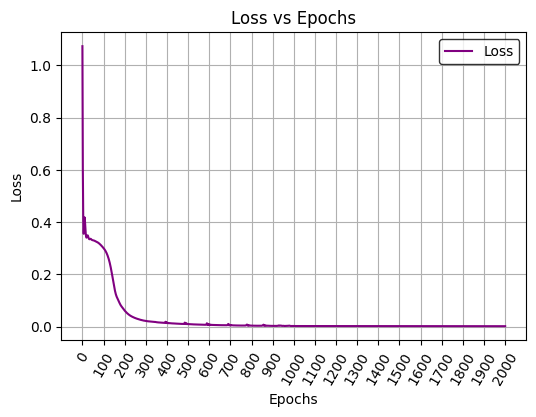

In [ ]:
#Απώλεια κάθε εποχής
fig = plt.figure(figsize=(6,4))

plt.plot(range(len(losses)), losses, label="Loss", color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(loc='upper right').get_frame().set_edgecolor('black')
plt.xticks(range(0, epoch+1, 100), rotation=60)
plt.grid(True)
plt.show()

u0_m:        torch.Size([400, 1])
v0_m:        torch.Size([400, 1])
psi0_abs_m:  torch.Size([400, 1])
ubl_m:        torch.Size([500, 1])
vbl_m:        torch.Size([500, 1])
psibl_abs_m:  torch.Size([500, 1])
ubr_m:        torch.Size([500, 1])
vbr_m:        torch.Size([500, 1])
psibr_abs_m:  torch.Size([500, 1])


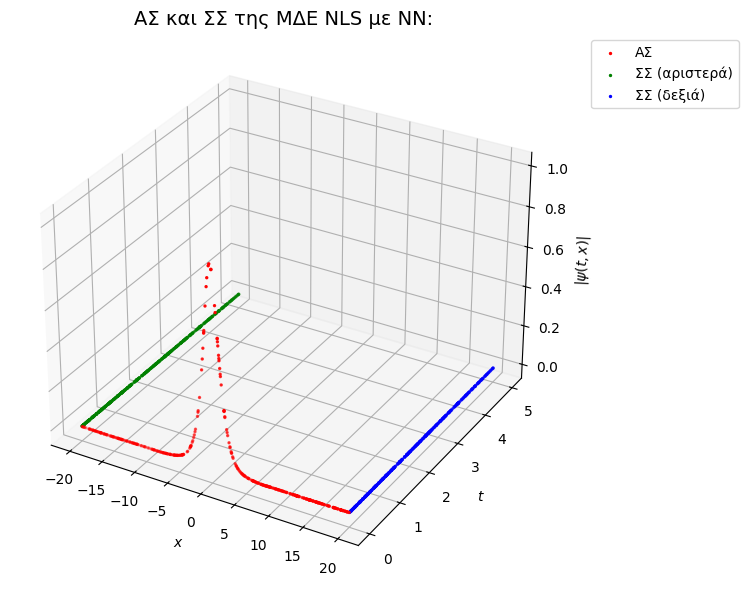

Στο t=Τ έχουμε min |ψ_0| = 0.000, max |ψ_0| = 0.993


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

#Τελική εκτίμηση μοντέλου Αρχικής Συνθήκης
u0_m, v0_m = model(torch.concat([t_0, x_0],dim=1))
psi0_abs_m = torch.sqrt(u0_m**2 + v0_m**2)
print(f'u0_m:       ',u0_m.shape)
print(f'v0_m:       ',v0_m.shape)
print(f'psi0_abs_m: ',psi0_abs_m.shape)

#Τελική εκτίμηση μοντέλου Συνοριακής Συνθήκης Αριστερά
ubl_m, vbl_m = model(torch.concat([t_b, x_b_left],dim=1))
psibl_abs_m = torch.sqrt(ubl_m**2 + vbl_m**2)
print(f'ubl_m:       ',ubl_m.shape)
print(f'vbl_m:       ',vbl_m.shape)
print(f'psibl_abs_m: ',psibl_abs_m.shape)

#Τελική εκτίμηση μοντέλου Συνοριακής Συνθήκης Δεξιά
ubr_m, vbr_m = model(torch.concat([t_b, x_b_right],dim=1))
psibr_abs_m = torch.sqrt(ubr_m**2 + vbr_m**2)
print(f'ubr_m:       ',ubr_m.shape)
print(f'vbr_m:       ',vbr_m.shape)
print(f'psibr_abs_m: ',psibr_abs_m.shape)


#Αρχική Συνθήκη
ax.scatter(x_0.detach().cpu().numpy(), t_0.detach().cpu().numpy(), psi0_abs_m.detach().cpu().numpy(), color='r', label='ΑΣ', s=2);

#Συνοριακή Συνθήκη (Αριστερά)
ax.scatter(x_b_left.detach().cpu().numpy(), t_b.detach().cpu().numpy(), psibl_abs_m.detach().cpu().numpy(), color='g', label='ΣΣ (αριστερά)', s=2);

#Συνοριακή Συνθήκη (Δεξιά)
ax.scatter(x_b_right.detach().cpu().numpy(), t_b.detach().cpu().numpy(), psibr_abs_m.detach().cpu().numpy(), color='b', label='ΣΣ (δεξιά)', s=2);


ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$|ψ(t,x)|$')
ax.set_title(r'ΑΣ και ΣΣ της ΜΔΕ NLS με NN:', fontsize=14);
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Μέγιστο πλάτος στο t_max
PSI0_min = psi0_abs_m.min().item()
PSI0_max = psi0_abs_m.max().item()
print(f'Στο t=Τ έχουμε min |ψ_0| = {PSI0_min:.3f}, max |ψ_0| = {PSI0_max:.3f}')

Για t=[0,T] έχουμε min |ψ| = 0.000, max |ψ| = 0.995
Στο t=Τ έχουμε min |ψ| = 0.000, max |ψ| = 0.987


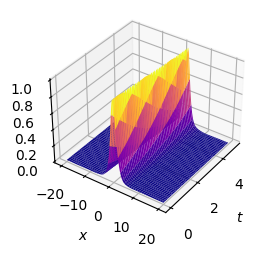

In [ ]:
from mpl_toolkits.mplot3d import Axes3D #βιβλιοθήκη για 3D γραφήματα

#Πλήθος διαστημάτων
N = 1000

tmin = tmin.cpu().item()
tmax = tmax.cpu().item()
xmin = xmin.cpu().item()
xmax = xmax.cpu().item()

#Δημιουργία σημείων
tspace = np.linspace(tmin, tmax, N + 1) #(N+1,1)
xspace = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(tspace, xspace) #(N+1,N+1) , (N+1,N+1)

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
u_pred, v_pred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1)
U = u_pred.cpu().detach().numpy().reshape(N+1,N+1)
V = v_pred.cpu().detach().numpy().reshape(N+1,N+1)
PSI = np.sqrt(U**2 + V**2)

#Γράφημα πρόβλεψης u(t,x) από δύο οπτικές γωνίες
fig = plt.figure(figsize=(6,4))
#fig.suptitle('Μοντελοποίηση ΜΔΕ Περιοδικής NLS με NN:\n Αποτελέσματα Προβλέψεων', fontsize=14)

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T, X, PSI, cmap='plasma');
ax1.view_init(35,35)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_zlabel('$|ψ(t,x)|$')
ax1.invert_xaxis()


print(f'Για t=[0,T] έχουμε min |ψ| = {PSI.min():.3f}, max |ψ| = {PSI.max():.3f}')

# Τελικό χρονικό βήμα
psi_final = PSI[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
psi_min = np.min(psi_final)
psi_max = np.max(psi_final)
print(f'Στο t=Τ έχουμε min |ψ| = {psi_min:.3f}, max |ψ| = {psi_max:.3f}')

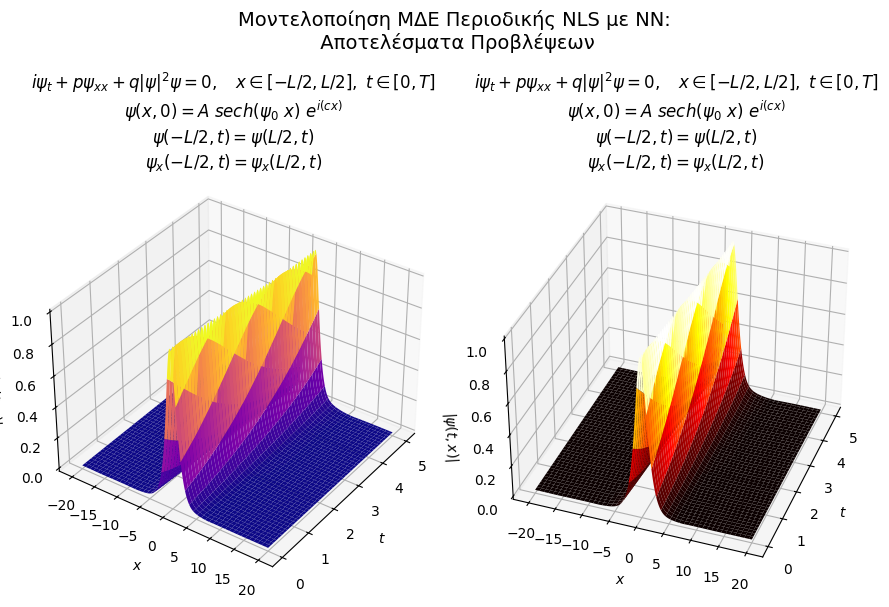

Για t=[0,T] έχουμε min |ψ| = 0.000, max |ψ| = 0.995
Στο t=Τ έχουμε min |ψ| = 0.000, max |ψ| = 0.987


In [ ]:
from mpl_toolkits.mplot3d import Axes3D #βιβλιοθήκη για 3D γραφήματα

#Πλήθος διαστημάτων
N = 1000

#tmin = tmin.cpu().item()
#tmax = tmax.cpu().item()
#xmin = xmin.cpu().item()
#xmax = xmax.cpu().item()

#Δημιουργία σημείων
tspace = np.linspace(tmin, tmax, N + 1) #(N+1,1)
xspace = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(tspace, xspace) #(N+1,N+1) , (N+1,N+1)

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
u_pred, v_pred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1)
U = u_pred.cpu().detach().numpy().reshape(N+1,N+1)
V = v_pred.cpu().detach().numpy().reshape(N+1,N+1)
PSI = np.sqrt(U**2 + V**2)

#Γράφημα πρόβλεψης u(t,x) από δύο οπτικές γωνίες
fig = plt.figure(figsize=(9,6))
fig.suptitle('Μοντελοποίηση ΜΔΕ Περιοδικής NLS με NN:\n Αποτελέσματα Προβλέψεων', fontsize=14)

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T, X, PSI, cmap='plasma');
ax1.view_init(35,35)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_zlabel('$|ψ(t,x)|$')
ax1.set_title(r'$i ψ_t + p ψ_{xx} + q |ψ|^2 ψ = 0,\quad x \in [-L/2, L/2],\ t \in [0,T]$' '\n'
              r'$ψ(x, 0) = A\ sech(ψ_0\ x)\ e^{i(c x)}$' '\n'
              r'$ψ(-L/2, t) = ψ(L/2, t)$' '\n'
              r'$ψ_x(-L/2, t) = ψ_x(L/2, t) $',
              fontsize=12);
ax1.invert_xaxis()


ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(T, X, PSI, cmap='hot');
ax2.view_init(35,20)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$x$')
ax2.set_zlabel('$|ψ(t,x)|$')
ax2.set_title(r'$i ψ_t + p ψ_{xx} + q |ψ|^2 ψ = 0,\quad x \in [-L/2, L/2],\ t \in [0,T]$' '\n'
              r'$ψ(x, 0) = A\ sech(ψ_0\ x)\ e^{i(c x)}$' '\n'
              r'$ψ(-L/2, t) = ψ(L/2, t)$' '\n'
              r'$ψ_x(-L/2, t) = ψ_x(L/2, t) $',
              fontsize=12);
ax2.invert_xaxis()

# Εμφάνιση του αποτελέσματος
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

print(f'Για t=[0,T] έχουμε min |ψ| = {PSI.min():.3f}, max |ψ| = {PSI.max():.3f}')

# Τελικό χρονικό βήμα
psi_final = PSI[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
psi_min = np.min(psi_final)
psi_max = np.max(psi_final)
print(f'Στο t=Τ έχουμε min |ψ| = {psi_min:.3f}, max |ψ| = {psi_max:.3f}')

In [ ]:
import plotly.graph_objects as go

#tmin = tmin.cpu().item()
#tmax = tmax.cpu().item()
#xmin = xmin.cpu().item()
#xmax = xmax.cpu().item()

#Δημιουργία σημείων
tspace = np.linspace(tmin, tmax, N + 1) #(N+1,1)
xspace = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(tspace, xspace) #(N+1,N+1) , (N+1,N+1)

#τίτλος
lines = (
    r'<b>Μοντελοποίηση ΜΔΕ Περιοδικής NLS Κύματος με NN<b>',
    r'$i ψ_t + p ψ_{xx} + q |ψ|^2 ψ = 0,\quad x \in [-L/2, L/2],\ t \in [0,T]$',
    r'$ψ(x, 0) = A\ sech(ψ_0\ x)\ e^{i(c x)}$',
    r'$ψ(-L/2, t) = ψ(L/2, t)$',
    r'$ψ_x(-L/2, t) = ψ_x(L/2, t) $'
)

#δημιουργία γραμμών τίτλου
annotations = []
x_pos = 0.05
start_y = 1.05
dy = -0.055

for i, line in enumerate(lines):
    annotations.append(
        dict(
          text=line,
          x=x_pos,
          y=start_y + i * dy,
          xref='paper',
          yref='paper',
          showarrow=False,
          font=dict(size=13 if i > 0 else 16, family="Arial"),
          align='center'
        )
    )

#αποκοπή των δεκαδικών ψηφίων από μιν μαξ τιμές για εμφάνιση
def truncation(x, decimals):
    factor = 10 ** decimals
    return torch.trunc(x * factor) / factor

PSI_tensor = torch.tensor(PSI)

min_PSI = truncation(torch.min(PSI_tensor), 1).item()
max_PSI = truncation(torch.max(PSI_tensor), 1).item()

#δημιουργία tickvals στη ράβδο
tickvals = [
    min_PSI + 0.001,
    truncation(torch.tensor((min_PSI + max_PSI)/2), 3).item(),
    max_PSI - 0.001
]



#δημιουργία 3D γραφήματος
fig = go.Figure(
    data=[
        go.Surface(
            x=tspace,
            y=xspace,
            z=PSI,
            colorscale='jet',
            colorbar=dict(
                title=dict(text='|ψ(x,t)|', side='top', font=dict(size=12)),
                tickvals = tickvals,
                x=0.88,         # αριστερά/δεξιά
                y=0.48,         # πάνω/κάτω
                len=0.9,        # πόσο "μακρύ" κάθετα
                thickness=20,   # πόσο "παχύ" οριζόντια
                tickfont=dict(size=10)
                )
            )
        ]
    )

fig.update_layout(
    margin=dict(l=20, r=20, t=50, b=20),
    scene=dict(
        xaxis=dict(title='t', autorange='reversed'),  #αντιστροφή άξονα x
        yaxis=dict(title='x'),
        zaxis=dict(title='|ψ(t,x)|')
    ),
    annotations=annotations
        )

fig.show()

print(f'Για t=[0,T] έχουμε min |ψ| = {PSI.min():.3f}, max |ψ| = {PSI.max():.3f}')

# Τελικό χρονικό βήμα
psi_final = PSI[:,-1]  # τελευταία γραμμή -> t_max

# Μέγιστο πλάτος στο t_max
psi_max = np.max(psi_final)
print(f'Στο t=tmax έχουμε max |ψ| = {psi_max:.3f}')


Output hidden; open in https://colab.research.google.com to view.

/tmp/ipython-input-2549859981.py:21: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-2549859981.py:22: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-2549859981.py:24: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



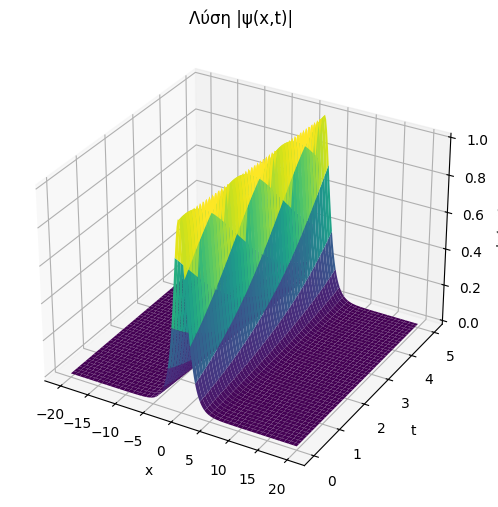

Στο t=Τ έχουμε min ψanal  = 0.000, max ψanal = 1.000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

psi_zero = psi_zero.numpy()
v_sp = v_sp.numpy()
c = c.numpy()
p = p.numpy()
omega = omega.numpy()

#σημεία
x = np.linspace(xmin, xmax, 200)
t = np.linspace(tmin, tmax, 200)

X, T = np.meshgrid(x, t)

temp_sech = psi_zero * (X - v_sp * T)
temp_sincos = c * X - omega * T

#λύση κύματος NLS
PSI_re = A * 1 / np.cosh(temp_sech) * np.cos( temp_sincos )
PSI_im = A * 1 / np.cosh(temp_sech) * np.sin( temp_sincos )

PSIanal_abs = np.sqrt(PSI_re**2 + PSI_im**2)

#γράφημα
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, PSIanal_abs, cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('|ψ(x,t)|')
ax.set_title('Λύση |ψ(x,t)|')

plt.show()

print(f'Στο t=Τ έχουμε min ψanal  = {PSIanal_abs.min():.3f}, max ψanal = {PSIanal_abs.max():.3f}')

###Διαφορές προσεγγίσεων:

*1) Αναλυτική - Pinn*

*2) Αναλυτική - RK4*

*3) Pinn - RK4*

x:   cpu
t:   cpu
X:   cpu
T:   cpu
A:   cpu
c:   cpu
v_sp:      cpu
omega:     cpu
psi_zero:  cpu


/tmp/ipython-input-197740233.py:29: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-197740233.py:30: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-197740233.py:32: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



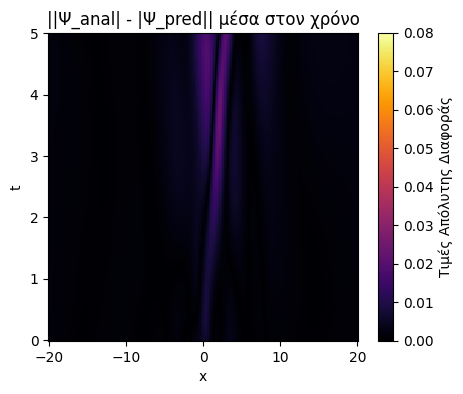

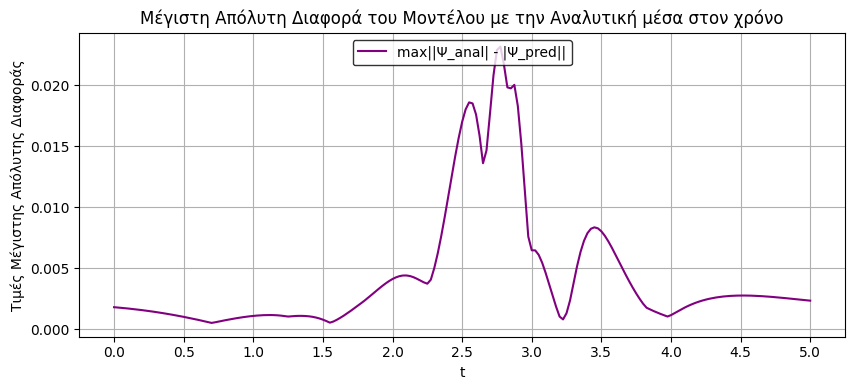

Στο t=Τ έχουμε min |Ψ_pred| = 0.000, max |Ψ_pred| = 0.985
Στο t=Τ έχουμε min |Ψ_anal| = 0.000, max |Ψ_anal| = 0.995


In [ ]:
#1)Μέγιστη Απόλυτη Διαφορά του Μοντέλου με την Αναλυτική μέσα στον χρόνο

dtype = torch.float32

N=200

#σημεία
x = np.linspace(xmin, xmax, N+1)
t = np.linspace(tmin, tmax, N+1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(t, x) #(N+1,N+1) , (N+1,N+1)

print(f'x:  ', x.device)
print(f't:  ', t.device)
print(f'X:  ', X.device)
print(f'T:  ', T.device)
print(f'A:  ', A.device)
print(f'c:  ', c.device)
print(f'v_sp:     ', v_sp.device)
print(f'omega:    ', omega.device)
print(f'psi_zero: ', psi_zero.device)

#αναλυτική λύση κύματος
temp_sech = psi_zero * (X - v_sp * T)
temp_sincos = c * X - omega * T

#λύση κύματος NLS
PSI_re = A * 1 / np.cosh(temp_sech) * np.cos( temp_sincos )
PSI_im = A * 1 / np.cosh(temp_sech) * np.sin( temp_sincos )

PSIanal_abs = np.sqrt(PSI_re**2 + PSI_im**2)


#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
u_pred, v_pred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1)
U = u_pred.cpu().detach().numpy()#.reshape(N+1,N+1)
V = v_pred.cpu().detach().numpy()#.reshape(N+1,N+1)
PSI = np.sqrt(U**2 + V**2)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1) και μετατροπή σε numpy
PSI_pred = PSI.reshape((N+1, N+1))#.detach().cpu().numpy()
PSIanal_abs_np = PSIanal_abs.detach().cpu().numpy()

#διαφορές
abs_diff = np.abs(PSI_pred - PSIanal_abs_np)  #απόλυτη τιμή διαφοράς (N+1,N+1)
#mean_diff = np.mean(abs_diff, axis=1)        #μέση τιμή διαφοράς (Ν+1,)
max_diff = np.max(abs_diff, axis=1)           #μέγιστη τιμή διαφοράς (N+1,)


#γραφήματα

#Πρώτο γράφημα: pcolormesh

#Τα μέγιστα ελάχιστα για την μπάρα
#vmin = np.min(abs_diff)
#vmax = np.max(abs_diff)
vmin = 0.0
vmax = 0.08

plt.figure(figsize=(5,4))
pcm = plt.pcolormesh(X, T, abs_diff, shading='auto', cmap='inferno', vmin=vmin, vmax=vmax)
plt.title('||Ψ_anal| - |Ψ_pred|| μέσα στον χρόνο')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(pcm, label='Τιμές Απόλυτης Διαφοράς')

#Δεύτερο γράφημα: γραμμικό
#plt.figure(figsize=(10,4))
#plt.plot(t, mean_diff, label='mean|U_anal - U_pred|', color='purple')
#plt.xlabel('t')
#plt.ylabel('Τιμές Μέσης Απόλυτης Διαφοράς')
#plt.title('Μέση Απόλυτη Διαφορά του Μοντέλου με την Αναλυτική μέσα στον χρόνο')
#plt.legend(loc='upper center').get_frame().set_edgecolor('black')
#plt.xticks(np.arange(0, tmax+0.1, 0.5))
#plt.grid(True)

#Τρίτο γράφημα: γραμμικό
plt.figure(figsize=(8.65,4))
plt.plot(t, max_diff, label='max||Ψ_anal| - |Ψ_pred||', color='purple')
plt.xlabel('t')
plt.ylabel('Τιμές Μέγιστης Απόλυτης Διαφοράς')
plt.title('Μέγιστη Απόλυτη Διαφορά του Μοντέλου με την Αναλυτική μέσα στον χρόνο')
plt.legend(loc='upper center').get_frame().set_edgecolor('black')
plt.xticks(np.arange(0, tmax+0.1, 0.5))
plt.grid(True)

plt.tight_layout()  # για να μην κολλάνε οι τίτλοι/άξονες
plt.show()

#Τελικό χρονικό βήμα
PSI_final = PSI_pred[:,-1]  # τελευταία γραμμή
PSIanal_final = PSIanal_abs_np[:,-1]

#Μέγιστο πλάτος στο t_max
PSI_min = np.min(PSI_final)
PSI_max = np.max(PSI_final)
print(f'Στο t=Τ έχουμε min |Ψ_pred| = {PSI_min:.3f}, max |Ψ_pred| = {PSI_max:.3f}')

PSIanal_min = np.min(PSIanal_final)
PSIanal_max = np.max(PSIanal_final)
print(f'Στο t=Τ έχουμε min |Ψ_anal| = {PSIanal_min:.3f}, max |Ψ_anal| = {PSIanal_max:.3f}')

In [ ]:
#ανέβασμα αρχείου Matlab

from google.colab import files
import os
import pandas as pd
import torch

filename = "psi_NLS_p.csv"

print(os.listdir())  # εμφανίζει όλα τα αρχεία στον φάκελο

#ρωτάω για αντικατάσταση αρχείου
if os.path.exists(filename):
    answer = input(f"Θέλεις να διαγράψω το αρχείο '{filename}' ; (ναι/οχι): ").strip().lower()

    if answer == "ναι":
        os.remove(filename)
        print(f"Το αρχείο '{filename}' διαγράφηκε.")
    else:
        print("Η διαγραφή ακυρώθηκε.")
else:
    print(f"Το αρχείο '{filename}' δεν υπάρχει.")


if os.path.exists(filename):
    print(f"Το αρχείο '{filename}' υπάρχει στον τρέχοντα φάκελο ({os.getcwd()}).")
    df = pd.read_csv(filename, header=None)
else:
    print(f"Το αρχείο '{filename}' ΔΕΝ υπάρχει στον τρέχοντα φάκελο ({os.getcwd()}).")
    upload = files.upload()  # θα ανοίξει παράθυρο για να ανεβάσω το CSV
    upload_filename = list(upload.keys())[0]   # το όνομα του πρώτου αρχείου
    df = pd.read_csv(upload_filename, header=None)

# Μετατροπή σε tensor
PSI_RK4 = torch.tensor(df.values, dtype=dtype)

print("Μέγεθος u:", PSI_RK4.shape)


['.config', 'psi_NLS_p.csv', 'sample_data']
Θέλεις να διαγράψω το αρχείο 'psi_NLS_p.csv' ; (ναι/οχι): οχι
Η διαγραφή ακυρώθηκε.
Το αρχείο 'psi_NLS_p.csv' υπάρχει στον τρέχοντα φάκελο (/content).
Μέγεθος u: torch.Size([844, 5001])


/tmp/ipython-input-1365562646.py:21: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-1365562646.py:22: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-1365562646.py:24: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



(5001, 844)
(844, 5001)


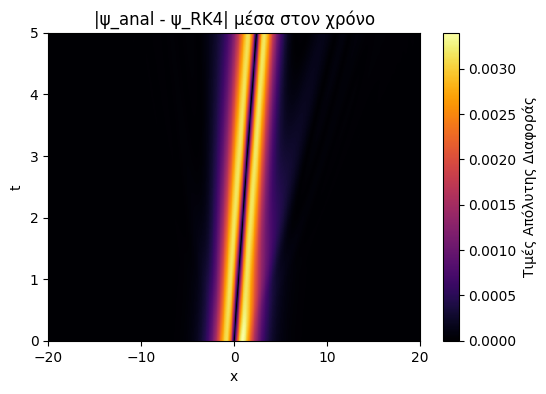

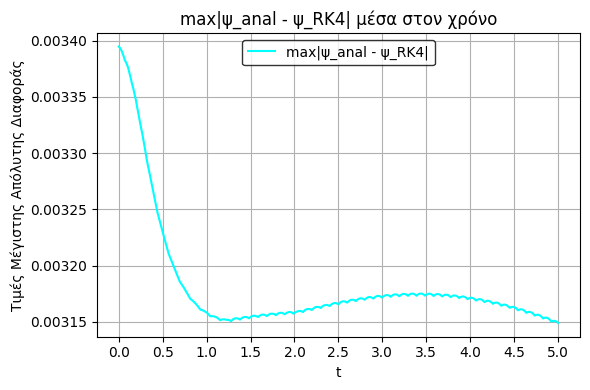

Στο t=Τ έχουμε min |ψ| = 0.000, max |ψ| = 1.000
Στο t=Τ έχουμε min |ψ_RK4| = 0.000, max |ψ_RK4| = 1.001


In [ ]:
#2)Διαφορές μεταξύ Μοντέλου και RK4 μέσα στον χρόνο
import numpy as np

#παίρνω τις διαστάσεις από το Matlab
Nx_rk4, Nt_rk4 = PSI_RK4.shape

#φτιάχνω ίδιες διαστάσεις για το μοντέλο για να επιτευχθεί η αφαίρεση
Nx = Nx_rk4
Nt = Nt_rk4

#σημεία
x = np.linspace(xmin, xmax, Nx)
t = np.linspace(tmin, tmax, Nt)
X, T = np.meshgrid(x, t)

#αναλυτική λύση κύματος NLS
temp_sech = psi_zero * (X - v_sp * T)
temp_sincos = c * X - omega * T

#λύση κύματος NLS
PSI_re = A * 1 / np.cosh(temp_sech) * np.cos( temp_sincos )
PSI_im = A * 1 / np.cosh(temp_sech) * np.sin( temp_sincos )

PSIanal_abs = np.sqrt(PSI_re**2 + PSI_im**2)

#μετατροπή σε numpy
PSI_anal_np = PSIanal_abs.detach().cpu().numpy()
PSI_RK4_np  = PSI_RK4.detach().cpu().numpy()

print(PSI_anal_np.shape)
print(PSI_RK4_np.shape)

abs_diff = np.abs(PSI_anal_np - PSI_RK4_np.T) #απόλυτη διαφορά
#mean_diff = np.mean(abs_diff, axis=1)     #μέση τιμή διαφοράς
max_diff = np.max(abs_diff, axis=1)       #μέγιστη τιμή διαφοράς


#γραφήματα

#Πρώτο γράφημα: pcolormesh
plt.figure(figsize=(6,4))
pcm = plt.pcolormesh(X, T, abs_diff, shading='auto', cmap='inferno')
plt.title('|ψ_anal - ψ_RK4| μέσα στον χρόνο')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(pcm, label='Τιμές Απόλυτης Διαφοράς')

#Δεύτερο γράφημα: γραμμικό
#plt.figure(figsize=(10,4))
#plt.plot(t, mean_diff, label='mean|ψ_anal - ψ_RK4|', color='purple')
#plt.xlabel('t')
#plt.ylabel('Τιμές Μέσης Απόλυτης Διαφοράς')
#plt.title('Μέση Απόλυτη Διαφορά της Αναλυτικής με την RK4 μέσα στον χρόνο')
#plt.legend(loc='upper center').get_frame().set_edgecolor('black')
#plt.xticks(np.arange(0, tmax+0.1, 0.5))
#plt.grid(True)

#Τρίτο γράφημα: γραμμικό
plt.figure(figsize=(6,4))
plt.plot(t, max_diff, label='max|ψ_anal - ψ_RK4|', color='cyan')
plt.xlabel('t')
plt.ylabel('Τιμές Μέγιστης Απόλυτης Διαφοράς')
plt.title('max|ψ_anal - ψ_RK4| μέσα στον χρόνο')
plt.legend(loc='upper center').get_frame().set_edgecolor('black')
plt.xticks(np.arange(0, tmax+0.1, 0.5))
plt.grid(True)

plt.tight_layout()  # για να μην κολλάνε οι τίτλοι/άξονες
plt.show()

#Τελικό χρονικό βήμα
PSIanal_final = PSI_anal_np[-1,:]  # τελευταία γραμμή
PSIRK4_final = PSI_RK4_np[:,-1]

#Μέγιστο πλάτος στο t_max
PSIanal_min = np.min(PSIanal_final)
PSIanal_max = np.max(PSIanal_final)
print(f'Στο t=Τ έχουμε min |ψ| = {PSIanal_min:.3f}, max |ψ| = {PSIanal_max:.3f}')

PSIRK4_min = np.min(PSIRK4_final)
PSIRK4_max = np.max(PSIRK4_final)
print(f'Στο t=Τ έχουμε min |ψ_RK4| = {PSIRK4_min:.3f}, max |ψ_RK4| = {PSIRK4_max:.3f}')

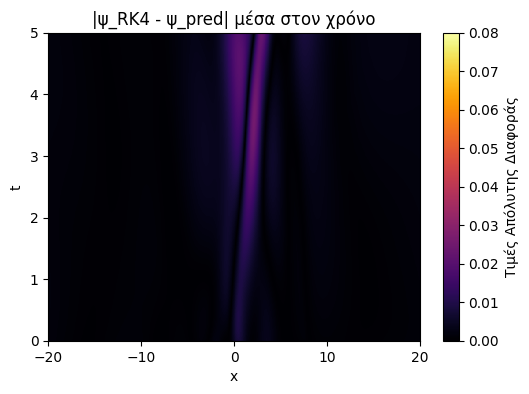

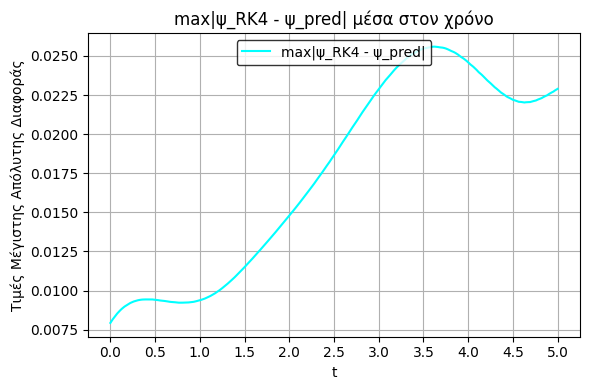

Στο t=Τ έχουμε min |ψ_pred| = 0.000, max |ψ_pred| = 0.987
Στο t=Τ έχουμε min |ψ_RK4| = 0.000, max |ψ_RK4| = 1.001


In [ ]:
#3)Διαφορές του Μοντέλου με την RK4 μέσα στον χρόνο

#dtype = torch.float32

#παίρνω τις διαστάσεις από το Matlab
Nx_rk4, Nt_rk4 = PSI_RK4.shape

#φτιάχνω ίδιες διαστάσεις για το μοντέλο για να επιτευχθεί η αφαίρεση
Nx = Nx_rk4
Nt = Nt_rk4

#σημεία
x = np.linspace(xmin, xmax, Nx)
t = np.linspace(tmin, tmax, Nt)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(t, x) #(N+1,N+1) , (N+1,N+1)

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
u_pred, v_pred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1)
U = u_pred.cpu().detach().numpy()#.reshape(N+1,N+1)
V = v_pred.cpu().detach().numpy()#.reshape(N+1,N+1)
PSI = np.sqrt(U**2 + V**2)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1) και μετατροπή σε numpy
PSI_pred = PSI.reshape(Nx, Nt)#.detach().numpy()
PSI_RK4_np  = PSI_RK4.detach().cpu().numpy()

abs_diff = np.abs(PSI_pred - PSI_RK4_np) #απόλυτη διαφορά (Ν+1,Ν+1)
#mean_diff = np.mean(abs_diff, axis=1)      #μέση τιμή διαφοράς (Ν+1,)
max_diff = np.max(abs_diff, axis=0)        #μέγιστη τιμή διαφοράς (Ν+1,)


#γραφήματα

#Πρώτο γράφημα: pcolormesh

#Τα μέγιστα ελάχιστα για την μπάρα
#vmin = np.min(abs_diff)
#vmax = np.max(abs_diff)
vmin = 0.0
vmax = 0.08

plt.figure(figsize=(6,4))
pcm = plt.pcolormesh(X, T, abs_diff, shading='auto', cmap='inferno', vmin=vmin, vmax=vmax)
plt.title('|ψ_RK4 - ψ_pred| μέσα στον χρόνο')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(pcm, label='Τιμές Απόλυτης Διαφοράς')

#Δεύτερο γράφημα: γραμμικό
#plt.figure(figsize=(10,4))
#plt.plot(t, mean_diff, label='mean|ψ_RK4 - ψ_pred|', color='purple')
#plt.xlabel('t')
#plt.ylabel('Τιμές Μέσης Απόλυτης Διαφοράς')
#plt.title('Μέση Απόλυτη Διαφορά του Μοντέλου με την RK4 μέσα στον χρόνο')
#plt.legend(loc='upper center').get_frame().set_edgecolor('black')
#plt.xticks(np.arange(0, tmax+0.1, 0.5))
#plt.grid(True)

#Τρίτο γράφημα: γραμμικό
plt.figure(figsize=(6,4))
plt.plot(t, max_diff, label='max|ψ_RK4 - ψ_pred|', color='cyan')
plt.xlabel('t')
plt.ylabel('Τιμές Μέγιστης Απόλυτης Διαφοράς')
plt.title('max|ψ_RK4 - ψ_pred| μέσα στον χρόνο')
plt.legend(loc='upper center').get_frame().set_edgecolor('black')
plt.xticks(np.arange(0, tmax+0.1, 0.5))
plt.grid(True)

plt.tight_layout()  # για να μην κολλάνε οι τίτλοι/άξονες
plt.show()

#Τελικό χρονικό βήμα
PSI_final = PSI_pred[:,-1]  # τελευταία γραμμή
PSIRK4_final = PSI_RK4_np[:,-1]

#Μέγιστο πλάτος στο t_max
PSI_min = np.min(PSI_final)
PSI_max = np.max(PSI_final)
print(f'Στο t=Τ έχουμε min |ψ_pred| = {PSI_min:.3f}, max |ψ_pred| = {PSI_max:.3f}')

PSIRK4_min = np.min(PSIRK4_final)
PSIRK4_max = np.max(PSIRK4_final)
print(f'Στο t=Τ έχουμε min |ψ_RK4| = {PSIRK4_min:.3f}, max |ψ_RK4| = {PSIRK4_max:.3f}')